# Using enterprise to analyze PTA data

In this notebook you will learn:
* How to use `enterprise` to interact with PTA data,
* How to search in PTA data for GWs using multiple pulsars,
* How to compute Bayes factors using `Hypermodel`,
* How to post-process your results.

If you are interested in working through this notebook, but do not want to install the software, we have prepared a [Google Colab notebook](https://colab.research.google.com/drive/1dwZ7ihDtpah9ATiPx2SJIWNYt9YJkQvF?usp=sharing)

By copying this notebook, you can install the software to your own Google Colab account and run the software without installation on your computer.

**Warning**: Sampling in this notebook is computationally intensive. It will take hours to sample properly. We have tried to cut it down somewhat while also leaving robust results that are indicative of what is actually done with a real analysis.

# Load packages and modules

In [2]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
import multiprocessing
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Optional mpi4py package is not installed.  MPI support is not available.


## Get par, tim, and noise files

In [3]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = './data'
if not os.path.isdir(datadir):
    datadir = '../data'
print(datadir)

../data


In [4]:
# for the entire pta
parfiles = sorted(glob.glob(datadir + '/par/*par'))
timfiles = sorted(glob.glob(datadir + '/tim/*tim'))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

## Load into Pulsar class list

* The `enterprise` Pulsar class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer to reference the `par` and `tim` files after this cell.

* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.

* You can also explicitly set the clock file to a version of `BIPM`, e.g. `BIPM(2018)`. This is less important, and you can let the code take the value from the `par` file.

* When you execute the following cell, you will get warnings like `WARNING: Could not find pulsar distance for PSR ...`. Don't worry! This is expected, and fine. Not all pulsars have well constrained distances, and will be set to `1 kpc` with a `20%` uncertainty.

## Read par and tim files into `enterprise` `Pulsar` objects

Note: This cell will take a few minutes to run.

In [5]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMX
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.

[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. ../par/B1855+09_NANOGrav_12yv3.gls.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[observatory.C:271] Warning: Assuming site '3' means 'ao'

[observatory.C:271] Warning: Assuming site '1' means 'gbt'


* We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 

* In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches.

* See `singlepulsar_whitenoise_analysis.ipynb` to see the methods used to find these values.

* The noise properties have been stored as `json` files, and are read in to a big parameter dictionary.

In [6]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

## Set up `enterprise` model for PTA GWB search (*verbose version*)
* The requirement for a pulsar to be used in the NANOGrav dataset is that the pulsar has at least three years of data. For the sake of saving some time, we will increase that limit to 6 years (cutting the number of pulsars in half). This will give us a good idea of what the process of analyzing a PTA looks like, while also reducing the computation time and giving similar results.

In [7]:
# OMIT THIS CELL TO USE THE FULL PTA -- THIS WILL TAKE MUCH LONGER
# TO SAMPLE THAN WITH THIS CELL

YR_SEC = 525600 * 60  # number of seconds in a year
YRS = 6  # number of years to cutoff the data at

# cut pulsars < X years:
new_psrs = []
for p in psrs:
    delta_t = p.toas.max() - p.toas.min()
    delta_t_yrs = delta_t / YR_SEC
    if delta_t_yrs > YRS:
        new_psrs.append(p)
        # print(p.name)
psrs = new_psrs
print(len(psrs), 'pulsars')

23 pulsars


In [8]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

* Usually, in a full PTA analysis we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name, later via the `set_default_params` method of `PTA`. 

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs. This selection is based on unique combination of backends and receivers.

In [9]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

### Parameters
* Another feature to notice is that **for upper limits** we do not use a `Uniform` prior on the log of the red-noise or GWB amplitude. Instead we use a `LinearExp` prior (short for linear-exponent prior), that is a prior of the form $p(x)\propto 10^x$. This is how we can still use the log of the parameter to sample but place a uniform prior on the parameter itself. We do this for both the red noise and GWB amplitude parameters. **For detection analyses** we still use a `Uniform` prior on the log of the GWB amplitude. 

* In order to save on computing time we do not include spatial correlations here. Instead we model the GWB as a common red process across all pulsars. In `enterprise` we can do this with a simple trick. We pre-initialize the parameters before passing them to the `Signal` model. In this way the *same* parameter instance is used for all pulsars. Lastly, we fix the spectral index of the GWB to be 13/3 (4.33) using the `Constant` parameter.

In [9]:
# white noise parameters
efac = parameter.Constant() 
equad = parameter.Constant() 
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# dm-variation parameters
log10_A_dm = parameter.Uniform(-20, -11)
gamma_dm = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18,-14)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

### Signals

In [10]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, log10_t2equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan, name='gw')

# for spatial correlations you can do...
# spatial correlations are covered in the hypermodel context later
# orf = utils.hd_orf()
# crn = gp_signals.FourierBasisCommonGP(cpl, orf,
#                                       components=30, Tspan=Tspan, name='gw')

# to add solar system ephemeris modeling...
bayesephem=False
if bayesephem:
    eph = deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

# timing model
tm = gp_signals.TimingModel(use_svd=True)

In [11]:
# full model
if bayesephem:
    s = ef + ec + rn + tm + eph + gw
else:
    s = ef + ec + rn + tm + gw

In [12]:
# intialize PTA (this cell will take a minute or two to run)
models = []
        
for p in psrs:    
    models.append(s(p))
    
pta = signal_base.PTA(models)

In [13]:
# set white noise parameters with dictionary
pta.set_default_params(params)

In [14]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [15]:
# set up the sampler:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = '../chains_pta_gwb'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=False)

### Sample!

This should take about an hour to sample. Note that a normal analysis would include from 1e6 to 5e6 samples. Here we would like it to finish a little faster, so we only look for 1.5e5 samples for about half the number of pulsars in the NANOGrav dataset. This should be enough to get an idea of what the posterior looks like.

In [16]:
# sampler for N steps
N = int(1e4)  # normally, we would use 5e6 samples (this will save time)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 10.00 percent in 16.019586 s Acceptance rate = 0.909

/home/czc/opt/miniconda3/envs/PTA3/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 90.00 percent in 118.562436 s Acceptance rate = 0.592556
Run Complete


## Plot output

In [17]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])

In [18]:
ind = list(pta.param_names).index('log10_A_gw')

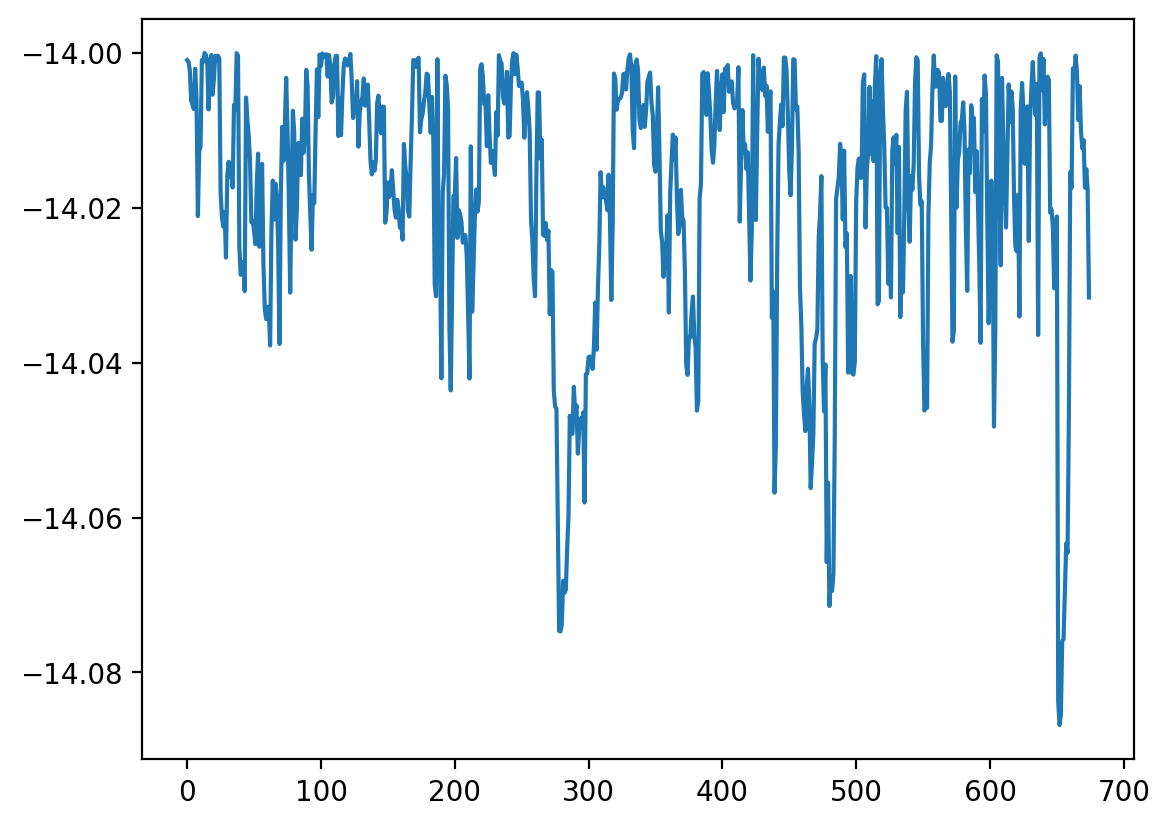

In [19]:
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])

Text(0, 0.5, 'PDF')

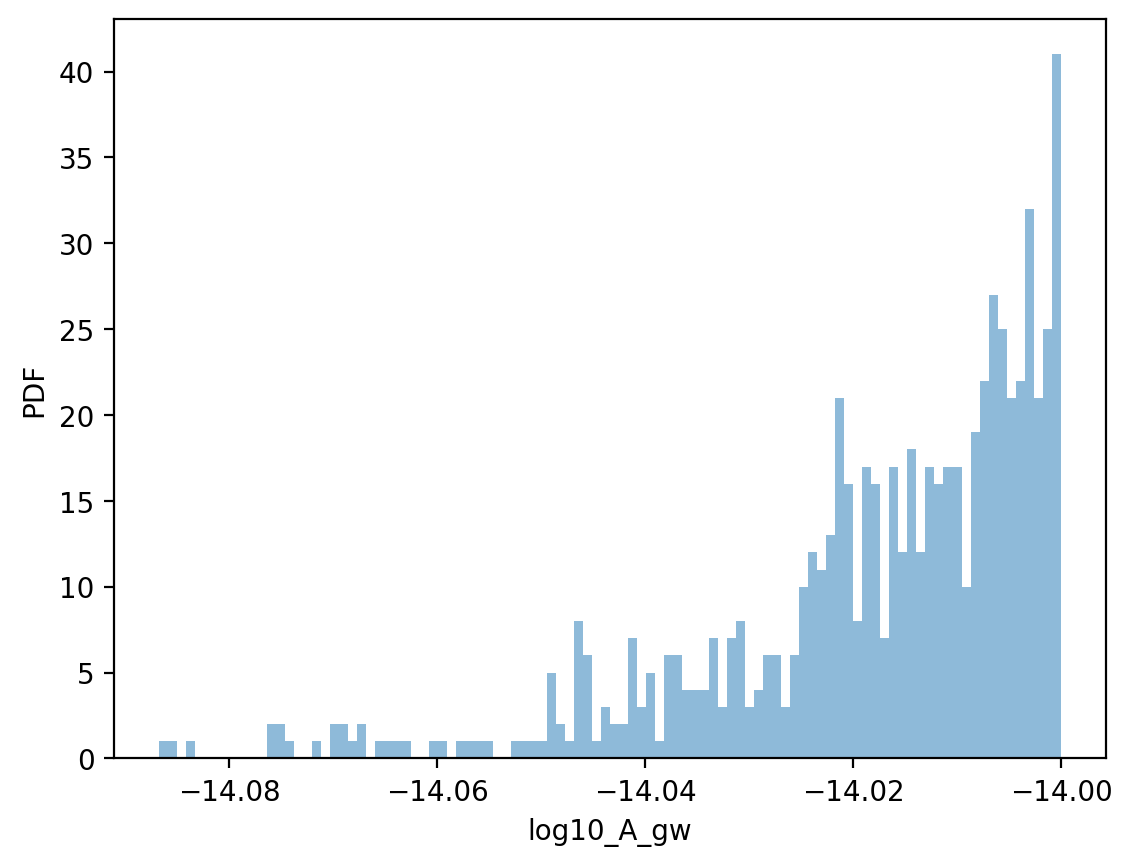

In [20]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 100, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')

In [21]:
hist = np.histogram(chain[burn:, pta.param_names.index('log10_A_gw')],
                          bins=70,
                          density=False)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

our_max = -14.001261029891385


## Discussion

* The posterior shows that there is a signal in the data. We can see this by examining the left side of the plot. If there were no detected signal here, the posterior would have a tail extending to the left as far as our prior extends (returning that part of the prior).
* `12p5yr_maxlike.json` shows `gw_log10_A` = -14.78361797461833 from the full 12.5 year analysis
* Our maximum is close at `gw_log10_A` = -14.509737862559803
* The important differences here are that we have fewer samples **AND** fewer pulsars that the full 12.5 year analysis.

## Now, the easy way to do all of this...

* Many of the steps above have been consolidated into convenient functions inside the `enterprise_extensions` package. In this section, we will show how to use these covenient functions.

In [22]:
import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

In [23]:
# this sets up the pta model (everything we did above) all in one cell
# model 2a includes:
#   fixed white noise parameters based on noisedict
#   common red noise signal (no correlation function) with 30 sampling frequencies
#   linear timing model
pta = models.model_2a(psrs, psd='powerlaw',
                      noisedict=params, components=30,
                      gamma_common=13/3)

In [24]:
# Setup an instance of a HyperModel.
# This doesn't mean we are doing model selection (yet!), but the 
# hypermodel module gives access to some nifty sampling schemes.
super_model = hypermodel.HyperModel({0: pta})

In [25]:
outDir = '../chains_pta_ext_gwb2'
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=False)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...



/home/czc/opt/miniconda3/envs/PTA3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [26]:
# sampler for N steps
N = int(1e4)  # normally this would be 5e6, but this saves time
x0 = super_model.initial_sample()

In [27]:
# sample: this should take about an hour
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

/home/czc/opt/miniconda3/envs/PTA3/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 90.00 percent in 124.544109 s Acceptance rate = 0.359556
Run Complete


In [28]:
# Read in chains and parameters
chain = np.loadtxt(outDir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

In [29]:
# this allows for some interesting post
# processing plots to be created quickly
pp = model_utils.PostProcessing(chain, pars)
# pp.plot_trace()  # traces of all parameters to diagnose sampling
hist_kwargs = {'bins':50, 'density':True}
# pp.plot_hist(hist_kwargs)

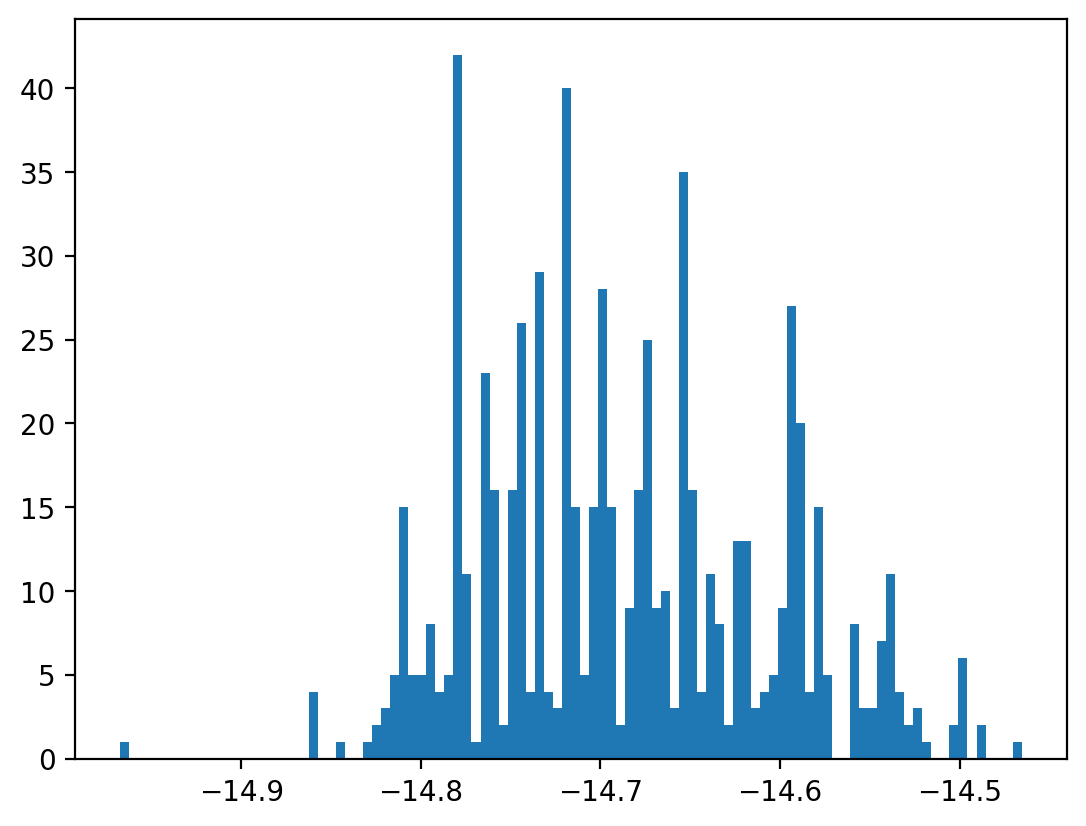

In [30]:
# Plot GW amplitude posterior
ind = list(pars).index('gw_log10_A')
plt.hist(chain[burn:,ind], bins=100);

In [31]:
# Compute maximum posterior value
hist = np.histogram(chain[burn:, pta.param_names.index('gw_log10_A')],
                          bins=100,
                          density=False)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

our_max = -14.781778441942901


* We want to be able to compute the Bayesian odds for a GWB in the data. This can be done using the hypermodel class, where we choose between a `model_2a` with a common (but uncorrelated) red process in the pulsars, and `model_1` with no GWB in the model.

* We typically perform detection-type analyses with uniform-in-log priors on all amplitude parameters for low-frequency processes. This is implemented below with `upper_limit` equal to `False`.

## Setup dictionary of PTA models
* `model_1` consists of a PTA with only intrinsic red noise
* `model_2a` includes a GWB term where we set the spectral index to 13/3
* In both cases, it is not necessary to include all of the keyword arguments but they are included here to show the different options that are available
* There are other model functions built into `enterprise_extensions`.
* Check out the docstrings of each function in the `models.py` file of `enterprise_extensions` for more information.

In [32]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_1(psrs, psd='powerlaw', noisedict=params, white_vary=False,
                        components=30, upper_limit=False, bayesephem=False,
                        be_type='orbel', is_wideband=False, use_dmdata=False,
                        select='backend')
pta[1] = models.model_2a(psrs, psd='powerlaw', noisedict=params, components=30,
                         n_rnfreqs = None, n_gwbfreqs=None, gamma_common=13/3,
                         delta_common=None, upper_limit=False, bayesephem=False,
                         be_type='orbel', white_vary=False, is_wideband=False,
                         use_dmdata=False, select='backend',
                         pshift=False, pseed=None, psr_models=False)

* In setting up the `HyperModel` in the next cell, we set weights to make the models sample more evenly.
* This will be taken into account when we compute the Bayes factor later.
* We also use an `empirical distribution` to tell the sampler what we found on previous runs to reduce the number of samples required for burn-in.

In [33]:
super_model = hypermodel.HyperModel(pta, log_weights=[10, 0])

## Sample

In [34]:
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=True,
                                    empirical_distr='12yr_emp_dist_RNonly_py3.pkl')

Adding empirical distributions failed!! Empirical distributions set to 'None'

Adding empirical proposals...

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



In [35]:
# This will take about an hour to sample
# To sample it properly will take 10+ hours
# sampler for N steps
N = int(1e4)  # 5e6 is a good number for a real analysis 
x0 = super_model.initial_sample()

In [36]:
# sample
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 90.00 percent in 151.489547 s Acceptance rate = 0.515222
Run Complete


## Post-process

In [37]:
chain = np.loadtxt(outDir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

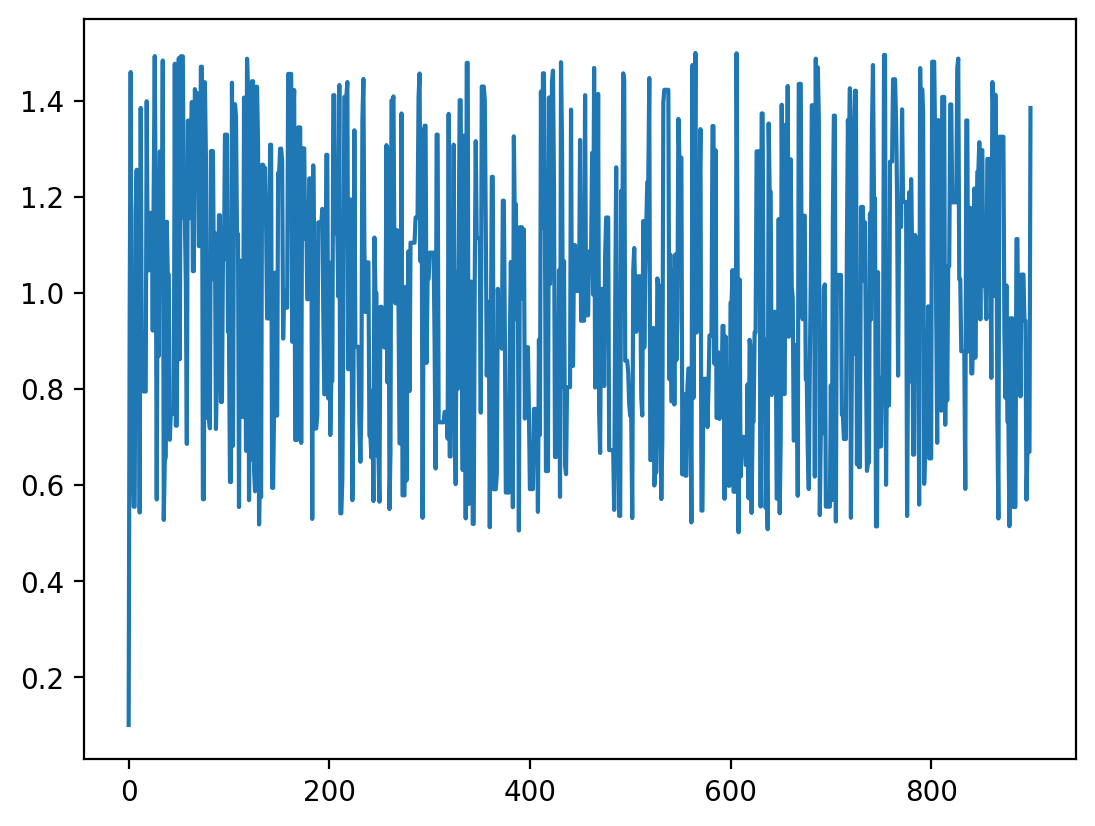

In [38]:
# Make trace-plot to diagnose sampling
ind_model = list(pars).index('nmodel')
plt.plot(chain[:, ind_model])

In [39]:
print(pars)

['B1855+09_red_noise_gamma' 'B1855+09_red_noise_log10_A'
 'B1937+21_red_noise_gamma' 'B1937+21_red_noise_log10_A'
 'J0030+0451_red_noise_gamma' 'J0030+0451_red_noise_log10_A'
 'J0613-0200_red_noise_gamma' 'J0613-0200_red_noise_log10_A'
 'J0645+5158_red_noise_gamma' 'J0645+5158_red_noise_log10_A'
 'J1012+5307_red_noise_gamma' 'J1012+5307_red_noise_log10_A'
 'J1024-0719_red_noise_gamma' 'J1024-0719_red_noise_log10_A'
 'J1455-3330_red_noise_gamma' 'J1455-3330_red_noise_log10_A'
 'J1600-3053_red_noise_gamma' 'J1600-3053_red_noise_log10_A'
 'J1614-2230_red_noise_gamma' 'J1614-2230_red_noise_log10_A'
 'J1640+2224_red_noise_gamma' 'J1640+2224_red_noise_log10_A'
 'J1643-1224_red_noise_gamma' 'J1643-1224_red_noise_log10_A'
 'J1713+0747_red_noise_gamma' 'J1713+0747_red_noise_log10_A'
 'J1738+0333_red_noise_gamma' 'J1738+0333_red_noise_log10_A'
 'J1744-1134_red_noise_gamma' 'J1744-1134_red_noise_log10_A'
 'J1903+0327_red_noise_gamma' 'J1903+0327_red_noise_log10_A'
 'J1909-3744_red_noise_gamma' 'J

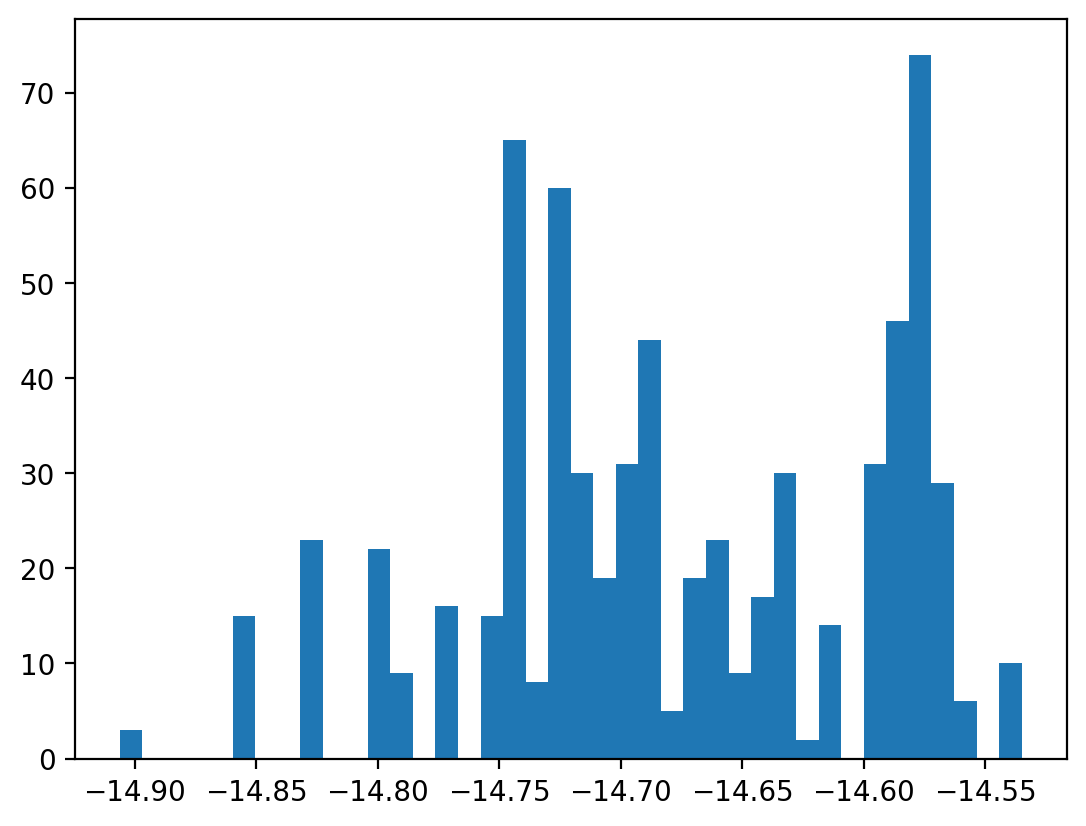

In [40]:
# Plot histgram for GW amplitude
chain_burn = chain[burn:,:]

ind_model = list(pars).index('nmodel')
ind_gwamp = list(pars).index('gw_log10_A')

# ORF = None
#plt.hist(chain_burn[chain_burn[:, ind_model] < 0.5, ind_gwamp], bins=40);

# ORF = Hellings & Downs
plt.hist(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], bins=40);

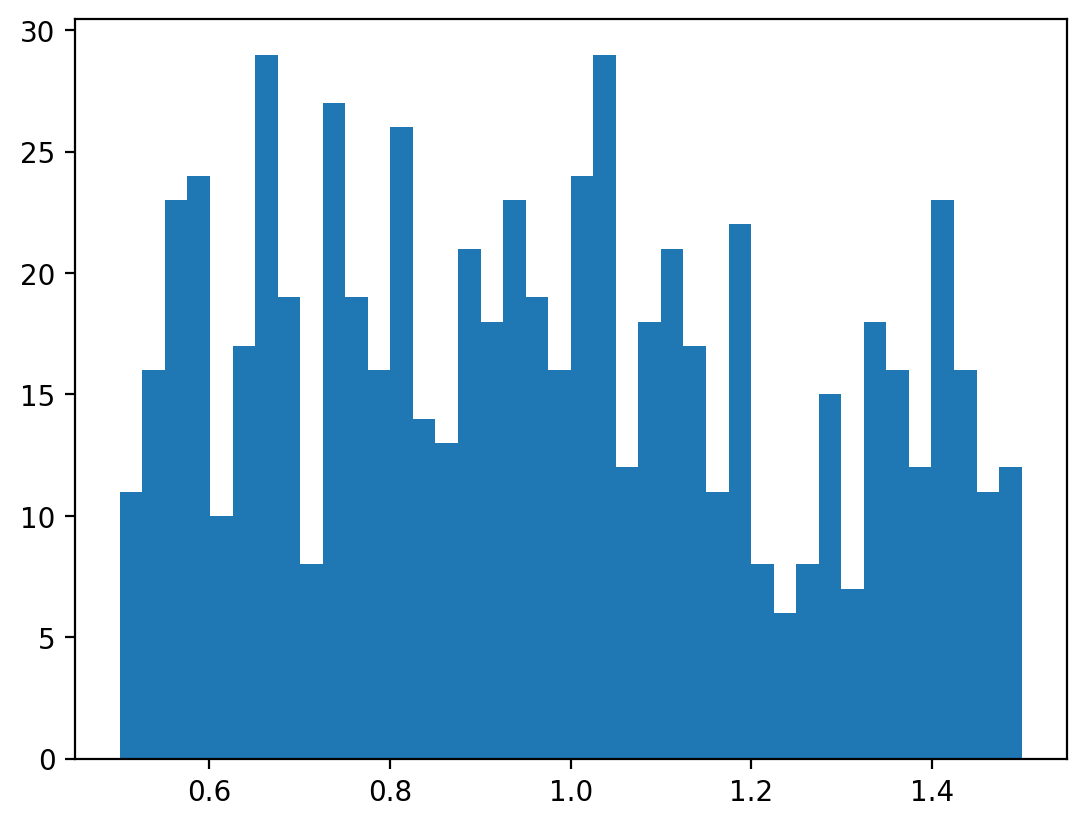

In [41]:
# Plot histogram for GWB model selection
# This will tell us how much we have sampled for each model
plt.hist(chain_burn[:, ind_model], bins=40);

### Hypermodel
* The hypermodel overwhelmingly favors the second model (nmodel > 0.5)
* We even weighted the first model by a factor of 10
* Ideally we would sample for longer and hopefully get some more samples in nmodel < 0.5

### Posterior odds ratio

* This gives the Bayesian odds between a model with no red process between pulsars (`model_1`), and a common (but uncorrelated) red process between pulsars (`model_2a`). 
* This will tell us if the pulsars prefer a common red noise term over no common term, but it will not tell us if this is the GWB.
* We will return to this in the next section to compare between a common (uncorrelated) red noise term and a red noise term with Hellings and Downs (HD) correlations.
* HD correlations would indicate that the common signal is a gravitational wave background.
* The Bayes Factor here indicates that there is **strong** evidence for a common red noise signal among pulsars

In [42]:
# The first number is the Bayes factor (BF) and the second number is the uncertainty on the BF
bf, unc = model_utils.odds_ratio(chain_burn[:, ind_model], models=[0,1])
print(bf, unc)

675.0 0.0


In [43]:
log10bf = np.log10(bf*10)  # we multiply by 10 to undo the weight
print(log10bf)

3.829303772831025


* Note that this Bayes factor is still a little low compared to the value found in the paper
* With more pulsars in the data set, we could recover the full log10BF of 4.5 for the `DE438` ephemeris.

# Reproducing figures from 12.5 year stochastic paper

## Download chains from 12.5 year stochastic paper

In [44]:
# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz -o ../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz

# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_cRN5freq_gammaVary_chain.gz -o ../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaVary_chain.gz

# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_cRN30freq_gammaVary_chain.gz -o ../downloaded_chains/12p5yr_DE438_model2a_cRN30freq_gammaVary_chain.gz

# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_PSDbrokenplaw_gammaVary_chain.gz -o ../downloaded_chains/12p5yr_DE438_model2a_PSDbrokenplaw_gammaVary_chain.gz

# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_PSDspectrum_chain.gz -o ../downloaded_chains/12p5yr_DE438_model2a_PSDspectrum_chain.gz

# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz -o ../downloaded_chains/12p5yr_DE438wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz

# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_INPOP19_model2a_cRN5freq_gammaFixed4.33_chain.gz -o ../downloaded_chains/12p5yr_INPOP19_model2a_cRN5freq_gammaFixed4.33_chain.gz

# !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_INPOP19wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz -o ../downloaded_chains/12p5yr_INPOP19wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz

## Figure 3

* In the last section we showed that there is strong evidence for a common-amplitude process which is the first arrow on Figure 3.
* In the first part of this section, we want to revisit this result and consider a process with HD correlations vs. the uncorrelated signal.

In [46]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_2a(psrs, psd='powerlaw', noisedict=params, components=30,
                         n_rnfreqs=None, n_gwbfreqs=None, gamma_common=None,
                         delta_common=None, upper_limit=False, bayesephem=False,
                         be_type='orbel', white_vary=False, is_wideband=False,
                         use_dmdata=False, select='backend',
                         pshift=False, pseed=None, psr_models=False)
pta[1] = models.model_3a(psrs, psd='powerlaw', noisedict=params, white_vary=False,
                         components=30, n_rnfreqs=None, n_gwbfreqs=None,
                         gamma_common=None, delta_common=None, upper_limit=False,
                         bayesephem=False, be_type='orbel', is_wideband=False,
                         use_dmdata=False, select='backend',
                         pshift=False, pseed=None, psr_models=False)


In [52]:
outDir = '../chains_pta_ext_gwb3'
super_model = hypermodel.HyperModel(pta)
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=True,
                                    empirical_distr='../data/12yr_emp_dist_RNonly_py3.pkl')
# This will take about an hour to sample
# To sample it properly will take 10+ hours
# sampler for N steps
N = int(1e4)  # 5e6 is a good number for a real analysis 
x0 = super_model.initial_sample()
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )


I can't open the empirical distribution pickle file!
Adding empirical distributions failed!! Empirical distributions set to 'None'

Adding empirical proposals...

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...

Finished 90.00 percent in 2571.823067 s Acceptance rate = 0.569
Run Complete


In [53]:
chain = np.loadtxt(outDir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

In [54]:
print(pars)

['B1855+09_red_noise_gamma' 'B1855+09_red_noise_log10_A'
 'B1937+21_red_noise_gamma' 'B1937+21_red_noise_log10_A'
 'J0030+0451_red_noise_gamma' 'J0030+0451_red_noise_log10_A'
 'J0613-0200_red_noise_gamma' 'J0613-0200_red_noise_log10_A'
 'J0645+5158_red_noise_gamma' 'J0645+5158_red_noise_log10_A'
 'J1012+5307_red_noise_gamma' 'J1012+5307_red_noise_log10_A'
 'J1024-0719_red_noise_gamma' 'J1024-0719_red_noise_log10_A'
 'J1455-3330_red_noise_gamma' 'J1455-3330_red_noise_log10_A'
 'J1600-3053_red_noise_gamma' 'J1600-3053_red_noise_log10_A'
 'J1614-2230_red_noise_gamma' 'J1614-2230_red_noise_log10_A'
 'J1640+2224_red_noise_gamma' 'J1640+2224_red_noise_log10_A'
 'J1643-1224_red_noise_gamma' 'J1643-1224_red_noise_log10_A'
 'J1713+0747_red_noise_gamma' 'J1713+0747_red_noise_log10_A'
 'J1738+0333_red_noise_gamma' 'J1738+0333_red_noise_log10_A'
 'J1744-1134_red_noise_gamma' 'J1744-1134_red_noise_log10_A'
 'J1903+0327_red_noise_gamma' 'J1903+0327_red_noise_log10_A'
 'J1909-3744_red_noise_gamma' 'J

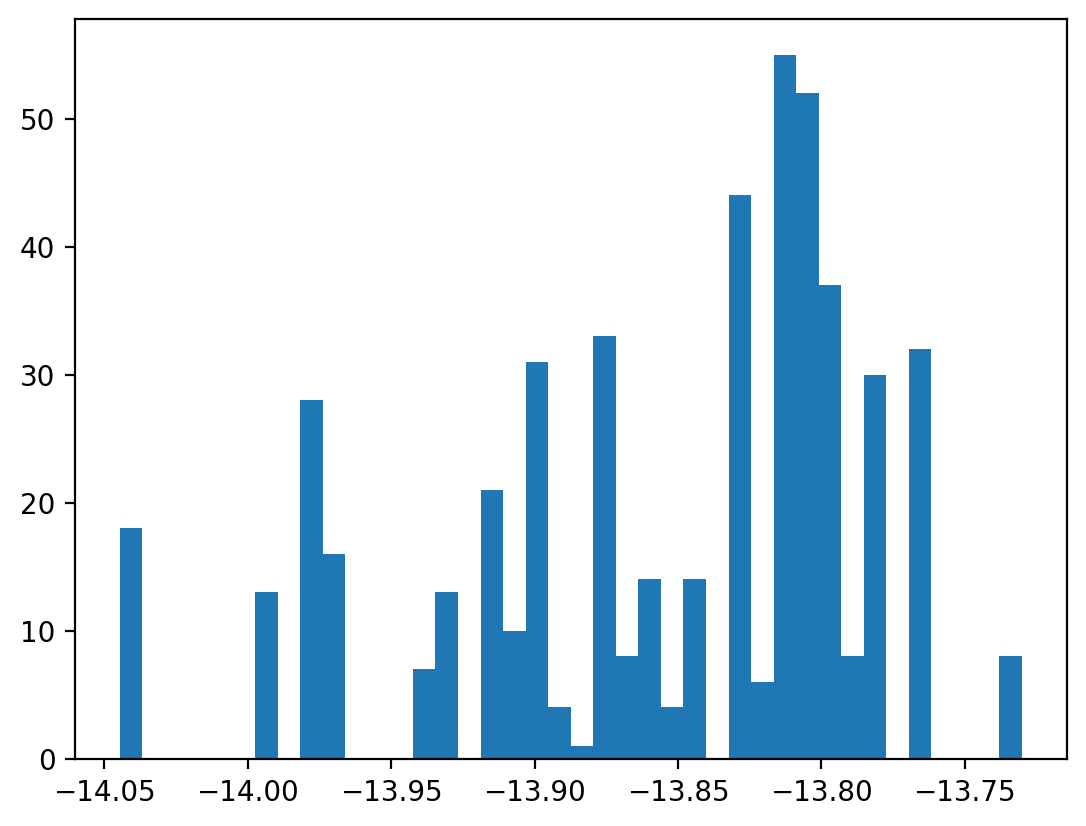

In [55]:
# Plot histgram for GW amplitude
chain_burn = chain[burn:,:]

ind_model = list(pars).index('nmodel')
ind_gwamp = list(pars).index('gw_log10_A')

# ORF = None
#plt.hist(chain_burn[chain_burn[:, ind_model] < 0.5, ind_gwamp], bins=40);

# ORF = Hellings & Downs
plt.hist(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], bins=40);

* It is clear from this plot that we are undersampling the posterior.
* However, the Bayes factor should be close according to the following plot
* We are apparently getting a decent amount of samples in each model

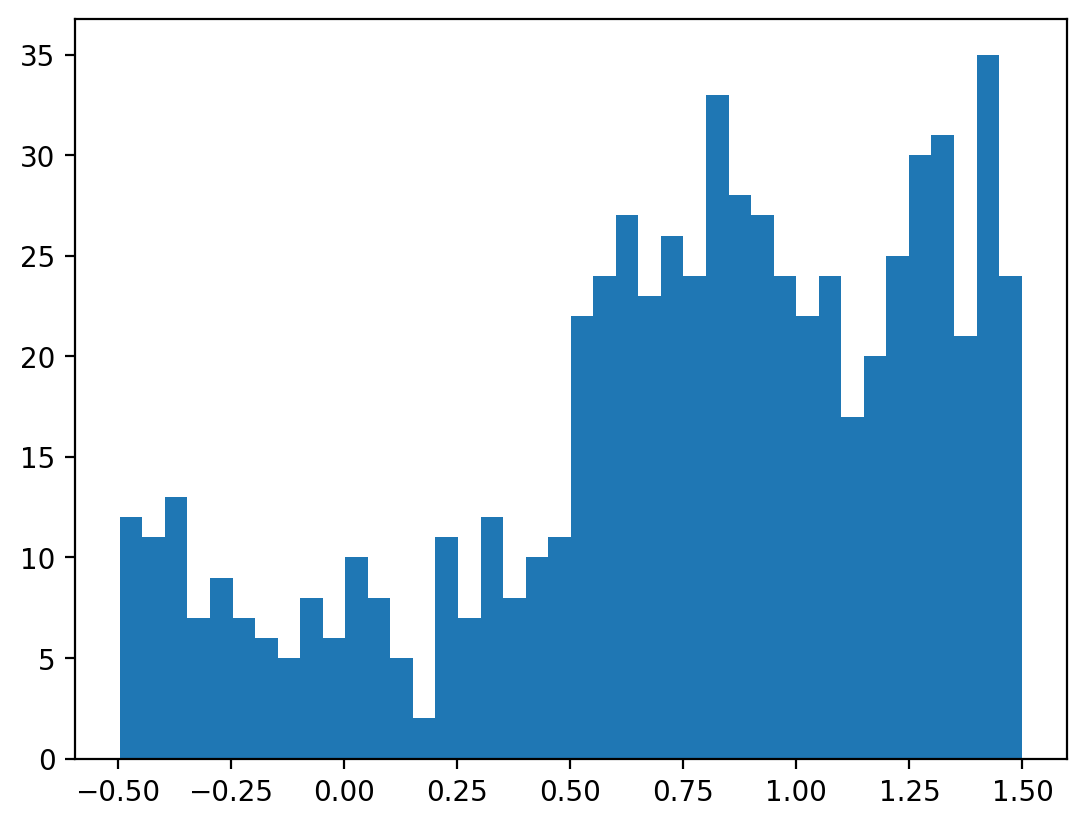

In [56]:
# Plot histogram for GWB model selection
# This will tell us how much we have sampled for each model
plt.hist(chain_burn[:, ind_model], bins=40);

In [57]:
# The first number is the Bayes factor (BF) and the second number is the uncertainty on the BF
bf, unc = model_utils.odds_ratio(chain_burn[:, ind_model], models=[0,1])
print(bf, unc)

3.017857142857143 0.44017149240901127


In [58]:
log10bf = np.log10(bf)
print(log10bf)

0.4796986776074731


* Once again we have sampled this at a much lower rate that is required to get the answer in the 12.5 year paper.
* We also have only half the pulsars.
* In order to get the exact number listed in the 12.5 year paper, we need to fill out the posterior distribution with more samples and include the rest of the pulsars.
* There is no clear evidence for HD correlations
* The upshot is that we can say with confidence that there is **something** in the 12.5 year data set that looks like a background, but at this point we can't say what exactly that something is.

## Figure 1

In [10]:
## Plotting Parameters For matplotlib
def figsize(scale):
    fig_width_pt = 513.17 #469.755    # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27         # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0    # Aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = fig_width * golden_mean              # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,
        'ytick.major.size':6,
        'ytick.minor.size':3,
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5)}

plt.rcParams.update(params)

In [11]:
# # Common Process Spectral Model Comparison Plot (Figure 1) # #

## Definition for powerlaw and broken powerlaw for left side of Figure 1
def powerlaw(f, log10_A=-16, gamma=4.3333):
    return np.sqrt((10**log10_A)**2 / 12.0 / np.pi**2 * const.fyr**(gamma-3) * f**(-gamma) * f[0])

def Broken_powerlaw(f, log10_A=-16, gamma=4.3333, log10_fb=-8, delta=0, kappa=0.1):
    hcf = (10**log10_A) * (f / const.fyr) ** ((3-gamma) / 2) * (1 + (f / 10**log10_fb) ** (1/kappa)) ** (kappa * (gamma - delta) / 2)
    return np.sqrt(hcf**2 / 12 / np.pi**2 / f**3 * f[0])

# determine placement of frequency components
Tspan = 12.893438736619137 * (365 * 86400) #psr.toas.max() - psr.toas.min() #
freqs_30 = 1.0 * np.arange(1, 31) / Tspan
freqs_5 = 1.0 * np.arange(1, 6) / Tspan

* In this next cell, we put some clips of code that can be run to sample the chains.
* We do not recommend running the chains for yourself without significant computational resources due to the large amount of time required to get the posterior sampled properly.

In [16]:
# import chains
# I did some thinning of my own since the chains were so massive

## broken power law
# models.model_2a(psrs, psd='turnover', noisedict=params, components=30,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=None,
#              delta_common=None, upper_limit=False, bayesephem=False,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_DE438_bplaw_vary = np.loadtxt('../downloaded_chains/12p5yr_DE438_model2a_PSDbrokenplaw_gammaVary_chain.gz', usecols=np.arange(-7,-3), skiprows=25000)
chain_DE438_bplaw_vary = chain_DE438_bplaw_vary[::5]
pars_DE438_bplaw_vary = np.loadtxt('../data/params_txt/12p5yr_DE438_model2a_PSDbrokenplaw_gammaVary_pars.txt', dtype=np.str)

## 5 frequency
# models.model_2a(psrs, psd='powerlaw', noisedict=params, components=5,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=None,
#              delta_common=None, upper_limit=False, bayesephem=False,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_DE438_vary = np.loadtxt('../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaVary_chain.gz', usecols=[90,91,92], skiprows=25000)
chain_DE438_vary = chain_DE438_vary[::4]

## 30 frequency
# models.model_2a(psrs, psd='powerlaw', noisedict=params, components=30,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=None,
#              delta_common=None, upper_limit=False, bayesephem=False,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_DE438_30f_vary = np.loadtxt('../downloaded_chains/12p5yr_DE438_model2a_cRN30freq_gammaVary_chain.gz', usecols=[90,91,92], skiprows=25000)
chain_DE438_30f_vary = chain_DE438_30f_vary[::4]

## Free Spectral
# models.model_2a(psrs, psd='spectrum', noisedict=params, components=30,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=None,
#              delta_common=None, upper_limit=False, bayesephem=False,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_DE438_FreeSpec = np.loadtxt('../downloaded_chains/12p5yr_DE438_model2a_PSDspectrum_chain.gz', usecols=np.arange(90,120), skiprows=30000)
chain_DE438_FreeSpec = chain_DE438_FreeSpec[::5]

/tmp/ipykernel_926239/762901012.py:14: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pars_DE438_bplaw_vary = np.loadtxt('../data/params_txt/12p5yr_DE438_model2a_PSDbrokenplaw_gammaVary_pars.txt', dtype=np.str)


In [17]:
# Pull MLV params
DE438_vary_Bpl_idx = np.argmax(chain_DE438_bplaw_vary[:,-1])
DE438_vary_5cRN_idx = np.argmax(chain_DE438_vary[:,-1])
DE438_vary_30cRN_idx = np.argmax(chain_DE438_30f_vary[:,-1])

# Make MLV Curves
PL_5freq = powerlaw(freqs_5, log10_A=chain_DE438_vary[:,1][DE438_vary_5cRN_idx], gamma=chain_DE438_vary[:,0][DE438_vary_5cRN_idx])
PL_30freq = powerlaw(freqs_30, log10_A=chain_DE438_30f_vary[:,1][DE438_vary_30cRN_idx], gamma=chain_DE438_30f_vary[:,0][DE438_vary_30cRN_idx])
bPL = Broken_powerlaw(freqs_30, log10_A=chain_DE438_bplaw_vary[:,1][DE438_vary_Bpl_idx], log10_fb=chain_DE438_bplaw_vary[:,2][DE438_vary_Bpl_idx], gamma=chain_DE438_bplaw_vary[:,0][DE438_vary_Bpl_idx])


In [18]:
# Create an array for the bPL, 5f, and 30f chains
## (to be able to make the 1-sigma regions and plot mean curves)
bPL_num = int(chain_DE438_bplaw_vary[:,0].shape[0] / 5.)
bPL_array = np.zeros((bPL_num,30))
for ii in range(bPL_num):
    bPL_array[ii] = np.log10(Broken_powerlaw(freqs_30, log10_A=chain_DE438_bplaw_vary[ii*5,1], log10_fb=chain_DE438_bplaw_vary[ii*5,2], gamma=chain_DE438_bplaw_vary[ii*5,0]))

PL_5freq_num = int(chain_DE438_vary[:,0].shape[0] / 5.)
PL_5freq_array = np.zeros((PL_5freq_num,5))
for ii in range(PL_5freq_num):
    PL_5freq_array[ii] = np.log10(powerlaw(freqs_5, log10_A=chain_DE438_vary[ii*5,1], gamma=chain_DE438_vary[ii*5,0]))

PL_30freq_num = int(chain_DE438_30f_vary[:,0].shape[0] / 5.)
PL_30freq_array = np.zeros((PL_30freq_num,30))
for ii in range(PL_30freq_num):
    PL_30freq_array[ii] = np.log10(powerlaw(freqs_30, log10_A=chain_DE438_30f_vary[ii*5,1], gamma=chain_DE438_30f_vary[ii*5,0]))


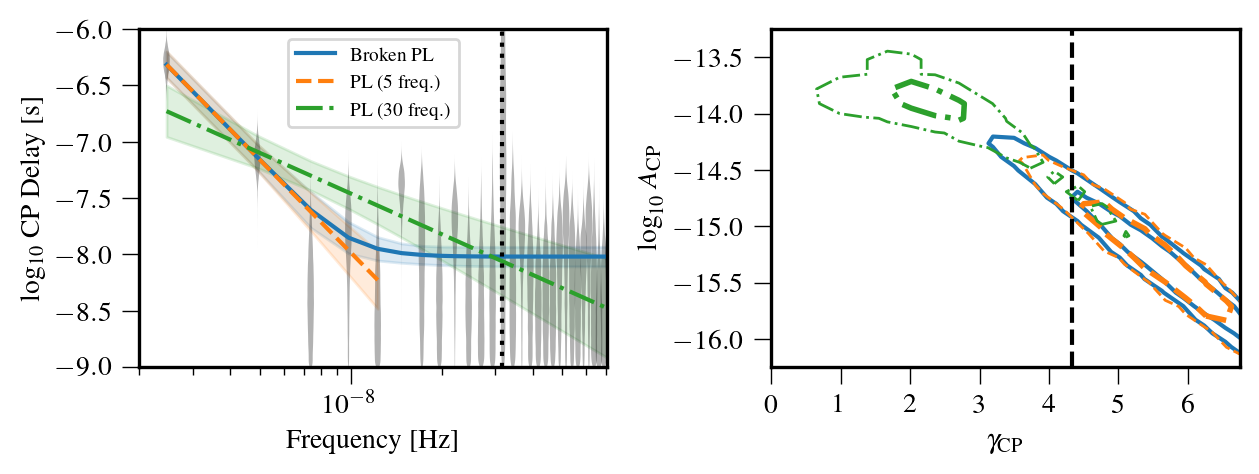

In [19]:
# Make Figure
plt.figure(figsize=[2*3.5503666805036667, 2.1942472810764047])

# Left Hand Side Of Plot
plt.subplot(1,2,1)

## Plot MLV Curves
#plt.semilogx(freqs_30, np.log10(bPL), color='C0', label='Broken PL')
#plt.plot(freqs_5, np.log10(PL_5freq), color='C1', label='PL (5 freq.)', ls='dashed')
#plt.plot(freqs_30, np.log10(PL_30freq), color='C2', label='PL (30 freq.)', ls='dashdot')

# Plot mean curves w/ 1-sigma regions
plt.semilogx(freqs_30, (bPL_array.mean(axis=0)), color='C0', label='Broken PL')
plt.fill_between(freqs_30, (bPL_array.mean(axis=0) - bPL_array.std(axis=0)), (bPL_array.mean(axis=0) + bPL_array.std(axis=0)), color='C0', alpha=0.15)

plt.semilogx(freqs_5, (PL_5freq_array.mean(axis=0)), color='C1', label='PL (5 freq.)', ls='dashed')
plt.fill_between(freqs_5, (PL_5freq_array.mean(axis=0) - PL_5freq_array.std(axis=0)), (PL_5freq_array.mean(axis=0) + PL_5freq_array.std(axis=0)), color='C1', alpha=0.15)

plt.semilogx(freqs_30, (PL_30freq_array.mean(axis=0)), color='C2', label='PL (30 freq.)', ls='dashdot')
plt.fill_between(freqs_30, (PL_30freq_array.mean(axis=0) - PL_30freq_array.std(axis=0)), (PL_30freq_array.mean(axis=0) + PL_30freq_array.std(axis=0)), color='C2', alpha=0.15)

# Plot Free Spectral Violin Plot
vpt = plt.violinplot(chain_DE438_FreeSpec, positions=(freqs_30), widths=0.05*freqs_30, showextrema=False)
for pc in vpt['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.3)

# Plot Labels
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'log$_{10}$ CP Delay [s]') # Residual [s]
plt.ylim(-9, -6)
plt.xlim(10**-8.7,10**-7.15)
plt.legend(loc=9)

# f = f_yr line
plt.axvline(3.17e-8, color='k', linestyle='dotted')

# Right Hand Plot
plt.subplot(1,2,2)

crn = corner.hist2d(chain_DE438_bplaw_vary[:,0], chain_DE438_bplaw_vary[:,1], color='C0', plot_datapoints=False, plot_density=False, levels=[0.67], countour_kwargs={'linewidths':2})
corner.hist2d(chain_DE438_bplaw_vary[:,0], chain_DE438_bplaw_vary[:,1], color='C0', plot_datapoints=False, plot_density=False, levels=[0.95], countour_kwargs={'linewidths':1}, ax=crn)

corner.hist2d(chain_DE438_vary[:,0], chain_DE438_vary[:,1], color='C1', plot_datapoints=False, plot_density=False, levels=[0.67], contour_kwargs={'linestyles':'dashed','linewidths':2}, ax=crn)
corner.hist2d(chain_DE438_vary[:,0], chain_DE438_vary[:,1], color='C1', plot_datapoints=False, plot_density=False, levels=[0.95], contour_kwargs={'linestyles':'dashed','linewidths':1}, ax=crn)

corner.hist2d(chain_DE438_30f_vary[:,0], chain_DE438_30f_vary[:,1], color='C2', plot_datapoints=False, plot_density=False, levels=[0.67], contour_kwargs={'linestyles':'dashdot','linewidths':2}, ax=crn)
corner.hist2d(chain_DE438_30f_vary[:,0], chain_DE438_30f_vary[:,1], color='C2', plot_datapoints=False, plot_density=False, levels=[0.95], contour_kwargs={'linestyles':'dashdot','linewidths':1}, ax=crn)

# gamma = 13/3 line
plt.axvline(13/3., color='k', linestyle='dashed')

# Plot Labels
plt.ylim(-16.25, -13.25)
plt.xlim(0,6.75)
plt.xticks([0,1,2,3,4,5,6])
plt.ylabel('$\log_{10}\, A_\mathrm{CP}$')
plt.xlabel(r'$\gamma_\mathrm{CP}$')

plt.subplots_adjust(wspace=0.35)
plt.show()

## Figure 2
* Note: The models labeled as such use the `INPOP19` ephemeris. This is changed up above when the data is imported (where we change `DE438` to `INPOP19`).

In [20]:
# # Common Process Posteriors

## Fixed Ephemeris Chains
pars_fixed = np.loadtxt('../data/params_txt/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt', dtype=np.str)

# models.model_2a(psrs, psd='powerlaw', noisedict=params, components=5,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=4.33,
#              delta_common=None, upper_limit=False, bayesephem=False,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_DE438 = np.loadtxt('../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[90], skiprows=100000)

# models.model_2a(psrs, psd='powerlaw', noisedict=params, components=5,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=4.33,
#              delta_common=None, upper_limit=False, bayesephem=False,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_INPOP19 = np.loadtxt('../downloaded_chains/12p5yr_INPOP19_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[90], skiprows=100000)

## BayesEphem w/SetIII Chains

pars_setIII = np.loadtxt('../data/params_txt/12p5yr_DE438wBayesEphem_model2a_cRN5freq_gammaFixed4.33_pars.txt', dtype=np.str)

# models.model_2a(psrs, psd='powerlaw', noisedict=params, components=5,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=4.33,
#              delta_common=None, upper_limit=False, bayesephem=True,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_DE438_s3 = np.loadtxt('../downloaded_chains/12p5yr_DE438wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[95], skiprows=100000)

# models.model_2a(psrs, psd='powerlaw', noisedict=params, components=5,
#              n_rnfreqs = None, n_gwbfreqs=None, gamma_common=4.33,
#              delta_common=None, upper_limit=False, bayesephem=True,
#              be_type='orbel', white_vary=False, is_wideband=False,
#              use_dmdata=False, select='backend',
#              pshift=False, pseed=None, psr_models=False)

chain_INPOP19_s3 = np.loadtxt('../downloaded_chains/12p5yr_INPOP19wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[95], skiprows=100000)


/tmp/ipykernel_926239/2057050226.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pars_fixed = np.loadtxt('../data/params_txt/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt', dtype=np.str)
/tmp/ipykernel_926239/2057050226.py:26: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pars_setIII = np.loadtxt('../data/params_txt/12p5yr_DE438wBayesEphem_mode

In [21]:
## Combine chains
gw_chains = []
#gw_chains.append(chain_DE430_s3[100000::10])
#gw_chains.append(chain_DE430[100000::10])
#gw_chains.append(chain_DE436_s3[100000::10])
#gw_chains.append(chain_DE436[100000::10])
gw_chains.append(chain_DE438_s3[100000::10])
gw_chains.append(chain_DE438[100000::10])
gw_chains.append(chain_INPOP19_s3[100000::10])
gw_chains.append(chain_INPOP19[100000::10])

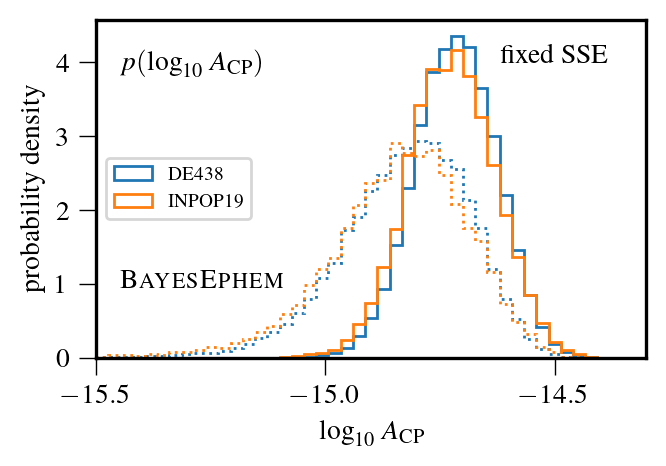

In [22]:
# Make Figure
figsize(0.5)

agwrange = [-15.5,-14.3]
agwbins = 45

# Plot Posteriors
for i,eph in enumerate(['DE438','INPOP19']):
    plt.hist(gw_chains[2*i], histtype='step', density=True, bins=agwbins, range=agwrange,
            color="C%d"%(i), ls=':')

    plt.hist(gw_chains[(2*i)+1], histtype='step', density=True, bins=agwbins, range=agwrange,
            color="C%d"%(i), label=eph)

# Set Plot Axes
plt.axis(xmin=agwrange[0],xmax=agwrange[1])
plt.xticks([-15.5,-15,-14.5])
plt.xlabel('$\log_{10}\, A_\mathrm{CP}$')
plt.ylabel('probability density')

# Add text
plt.text(-15.45,3.9,'$p(\log_{10}\, A_\mathrm{CP})$')
plt.text(-14.5,4,'fixed SSE',ha='center')
plt.text(-15.27,0.95,r'$\textsc{BayesEphem}$',ha='center')

# Add legend
plt.legend(loc=6)

# plt.savefig('Figure2.png',bbox_inches='tight')
plt.show()

* This concludes the GWB tutorial. Next, we move on to the frequentist optimal statistic analysis tutorial.